# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**
- $L_j = 0$: Job ist **pünktlich**
- $L_j < 0$: Job ist **zu früh** fertig

$\min \; Z =
\underbrace{
w_{\text{main}} \cdot \left(
w_t \cdot \sum_{j \in \mathcal{J}} T_j
+ w_e \cdot \sum_{j \in \mathcal{J}} E_j
+ w_{\text{first}} \cdot \sum_{j \in \mathcal{J}} F_j
\right)
}_{\text{Lateness-Komponente}}
\; + \;
\underbrace{
(1 - w_{\text{main}}) \cdot \sum_{(j,o) \in \mathcal{P}} D_{jo}
}_{\text{Abweichungskomponente}}$

$\mathcal{J}$ … Menge aller Jobs
$\mathcal{P}$ … Menge aller Operationen mit vorherigem Planbezug

$T_j = \max(0, \text{Ende}_j - \text{Deadline}_j)$ … Tardiness (Verspätung)
$E_j = \max(0, \text{Deadline}_j - \text{Ende}_j)$ … Earliness (zu früh)
$F_j = \max(0, \text{Wunschstart}_j - \text{Start}_{j,0})$ … Frühstartstrafe der ersten Operation

$D_{jo} =
\begin{cases}
|S_{jo}^{\text{neu}} - S_{jo}^{\text{alt}}| & \text{(Startzeitabweichung)} \\
\text{Anzahl der Inversionen (Kendall-Tau)} & \text{(Reihenfolgeabweichung)}
\end{cases}$


In [1]:
import pandas as pd

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.rolling_process.rolling_filter import *
from src.utils.editor import enrich_schedule_dframe

from src.utils.logging import print_experiment_log

# Analysis utils
from src.utils.analysis_basics import check_constraints as check
from src.utils.analysis_basics.check_lateness import get_jobs_with_lateness_metrics, get_jobs_aggregated
from src.utils.analysis.compare_sequences import get_comparison_dataframe, compute_sum_levenshtein_distance, \
    compute_mean_kendall_tau, get_shared_operations_number

# Solver
from src.solvers.converter import get_job_ops_dict, get_times_dict, get_schedule_dframe, get_active_ops
from src.solvers.cp.lateness import solve_jssp_lateness_with_start_deviation_minimization, \
    solve_jssp_lateness_with_order_deviation_minimization

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Database and Collections
from src.classes.Query import RoutingQuery, JobQuery  # for database access
from src.classes.Initializer import ExperimentInitializer

from src.classes.Collection import JobMixCollection, RoutingCollection

In [3]:
# Hard termination condition for schedulers
max_time = 60*2     # 2 min

# File paths
examples_data_path = get_path("data", "examples")
basic_data_path = get_path("data", "basic")

# Simulation
simulation = ProductionSimulation(sigma = 0.2)

In [4]:
# Load routings file
routings = RoutingQuery.get_by_source_name(source_name="Fisher and Thompson 10x10")
RoutingCollection(routings).to_dataframe()


,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


In [5]:
for routing_id, routing in RoutingCollection(routings).items():
    print(f"Routing: {routing_id}")
    for op in routing.operations:
        print(f"  Operation {op.position_number}: Machine {op.machine}, Duration {op.duration}")

Routing: 0
  Operation 0: Machine M00, Duration 29
  Operation 1: Machine M01, Duration 78
  Operation 2: Machine M02, Duration 9
  Operation 3: Machine M03, Duration 36
  Operation 4: Machine M04, Duration 49
  Operation 5: Machine M05, Duration 11
  Operation 6: Machine M06, Duration 62
  Operation 7: Machine M07, Duration 56
  Operation 8: Machine M08, Duration 44
  Operation 9: Machine M09, Duration 21
Routing: 1
  Operation 0: Machine M00, Duration 43
  Operation 1: Machine M02, Duration 90
  Operation 2: Machine M04, Duration 75
  Operation 3: Machine M09, Duration 11
  Operation 4: Machine M03, Duration 69
  Operation 5: Machine M01, Duration 28
  Operation 6: Machine M06, Duration 46
  Operation 7: Machine M05, Duration 46
  Operation 8: Machine M07, Duration 72
  Operation 9: Machine M08, Duration 30
Routing: 2
  Operation 0: Machine M01, Duration 91
  Operation 1: Machine M00, Duration 85
  Operation 2: Machine M03, Duration 39
  Operation 3: Machine M02, Duration 74
  Operat

In [6]:
jobs = JobQuery.get_by_experiment_id(1)
job_collection = JobMixCollection(jobs)
job_collection.to_information_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J001-0000,7,0,1440,4620
1,J001-0001,6,45,1440,3671
2,J001-0002,1,107,1440,4381
3,J001-0003,5,147,1440,4011
4,J001-0004,4,186,1440,5145
5,J001-0005,2,377,1440,3877
...,...,...,...,...,...
8122,J001-8122,7,519437,519840,523328
8123,J001-8123,1,519489,519840,523507
8124,J001-8124,8,519533,519840,524382


## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [7]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [8]:
# New jobs that must be scheduled
current_job_times_collection = job_collection.get_subset_by_earliest_start(earliest_start=day_start)


In [9]:
df_jssp_current = current_job_times_collection.to_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,J001-0000,7,0,M02,None,31,None,1440,4620
1,J001-0000,7,1,M00,None,86,None,1440,4620
2,J001-0000,7,2,M01,None,46,None,1440,4620
3,J001-0000,7,3,M05,None,74,None,1440,4620
4,J001-0000,7,4,M04,None,32,None,1440,4620
5,J001-0000,7,5,M06,None,88,None,1440,4620
...,...,...,...,...,...,...,...,...,...
164,J001-0016,7,4,M04,None,32,None,1440,3460
165,J001-0016,7,5,M06,None,88,None,1440,3460
166,J001-0016,7,6,M08,None,19,None,1440,3460


In [10]:
df_jobs_times_current = current_job_times_collection.to_information_dataframe()
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J001-0000,7,0,1440,4620
1,J001-0001,6,45,1440,3671
2,J001-0002,1,107,1440,4381
3,J001-0003,5,147,1440,4011
4,J001-0004,4,186,1440,5145
5,J001-0005,2,377,1440,3877
...,...,...,...,...,...
11,J001-0011,2,856,1440,5194
12,J001-0012,8,921,1440,5474
13,J001-0013,4,1001,1440,5554


### Scheduling Preperation

In [11]:
job_ops_dict = get_job_ops_dict(df_jssp_current)
job_ops_dict

{'J001-0000': [(0, 'M02', 31),
  (1, 'M00', 86),
  (2, 'M01', 46),
  (3, 'M05', 74),
  (4, 'M04', 32),
  (5, 'M06', 88),
  (6, 'M08', 19),
  (7, 'M09', 48),
  (8, 'M07', 36),
  (9, 'M03', 79)],
 'J001-0001': [(0, 'M01', 46),
  (1, 'M00', 37),
  (2, 'M03', 61),
  (3, 'M02', 13),
  (4, 'M06', 32),
  (5, 'M05', 21),
  (6, 'M09', 32),
  (7, 'M08', 89),
  (8, 'M07', 30),
  (9, 'M04', 55)],
 'J001-0002': [(0, 'M00', 43),
  (1, 'M02', 90),
  (2, 'M04', 75),
  (3, 'M09', 11),
  (4, 'M03', 69),
  (5, 'M01', 28),
  (6, 'M06', 46),
  (7, 'M05', 46),
  (8, 'M07', 72),
  (9, 'M08', 30)],
 'J001-0003': [(0, 'M02', 84),
  (1, 'M01', 2),
  (2, 'M05', 52),
  (3, 'M03', 95),
  (4, 'M08', 48),
  (5, 'M09', 72),
  (6, 'M00', 47),
  (7, 'M06', 65),
  (8, 'M04', 6),
  (9, 'M07', 25)],
 'J001-0004': [(0, 'M02', 14),
  (1, 'M00', 6),
  (2, 'M01', 22),
  (3, 'M05', 61),
  (4, 'M03', 26),
  (5, 'M04', 69),
  (6, 'M08', 21),
  (7, 'M07', 49),
  (8, 'M09', 72),
  (9, 'M06', 53)],
 'J001-0005': [(0, 'M01', 91),
  

In [12]:
times_dict = get_times_dict(df_jobs_times_current)
times_dict

{'J001-0000': (1440, 4620),
 'J001-0001': (1440, 3671),
 'J001-0002': (1440, 4381),
 'J001-0003': (1440, 4011),
 'J001-0004': (1440, 5145),
 'J001-0005': (1440, 3877),
 'J001-0006': (1440, 4824),
 'J001-0007': (1440, 3346),
 'J001-0008': (1440, 3794),
 'J001-0009': (1440, 3635),
 'J001-0010': (1440, 4810),
 'J001-0011': (1440, 5194),
 'J001-0012': (1440, 5474),
 'J001-0013': (1440, 5554),
 'J001-0014': (1440, 5492),
 'J001-0015': (1440, 5064),
 'J001-0016': (1440, 3460)}

### Schedule

In [13]:
schedule, _ = solve_jssp_lateness_with_start_deviation_minimization(
        job_ops=job_ops_dict,
        times_dict=times_dict,
        previous_schedule=None,
        active_ops=None,
        w_t= 10, w_e=2, w_first=1,
        main_pct=1, duration_buffer_factor = 2,
        schedule_start=day_start, msg=False,
        solver_time_limit=max_time, solver_relative_gap_limit=0.05
    )

In [14]:
df_schedule = get_schedule_dframe(schedule)
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_01.csv", index=False)

In [15]:
job_schedule_collection = JobMixCollection.from_schedule_dataframe(df_schedule)
job_schedule_collection.to_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,J001-0000,None,0,M02,3542,31,3573,0,None
1,J001-0000,None,1,M00,3573,86,3659,0,None
2,J001-0000,None,2,M01,3677,46,3723,0,None
3,J001-0000,None,3,M05,3769,74,3843,0,None
4,J001-0000,None,4,M04,3877,32,3909,0,None
5,J001-0000,None,5,M06,3909,88,3997,0,None
...,...,...,...,...,...,...,...,...,...
164,J001-0016,None,4,M04,2619,32,2651,0,None
165,J001-0016,None,5,M06,2651,88,2739,0,None
166,J001-0016,None,6,M08,2739,19,2758,0,None


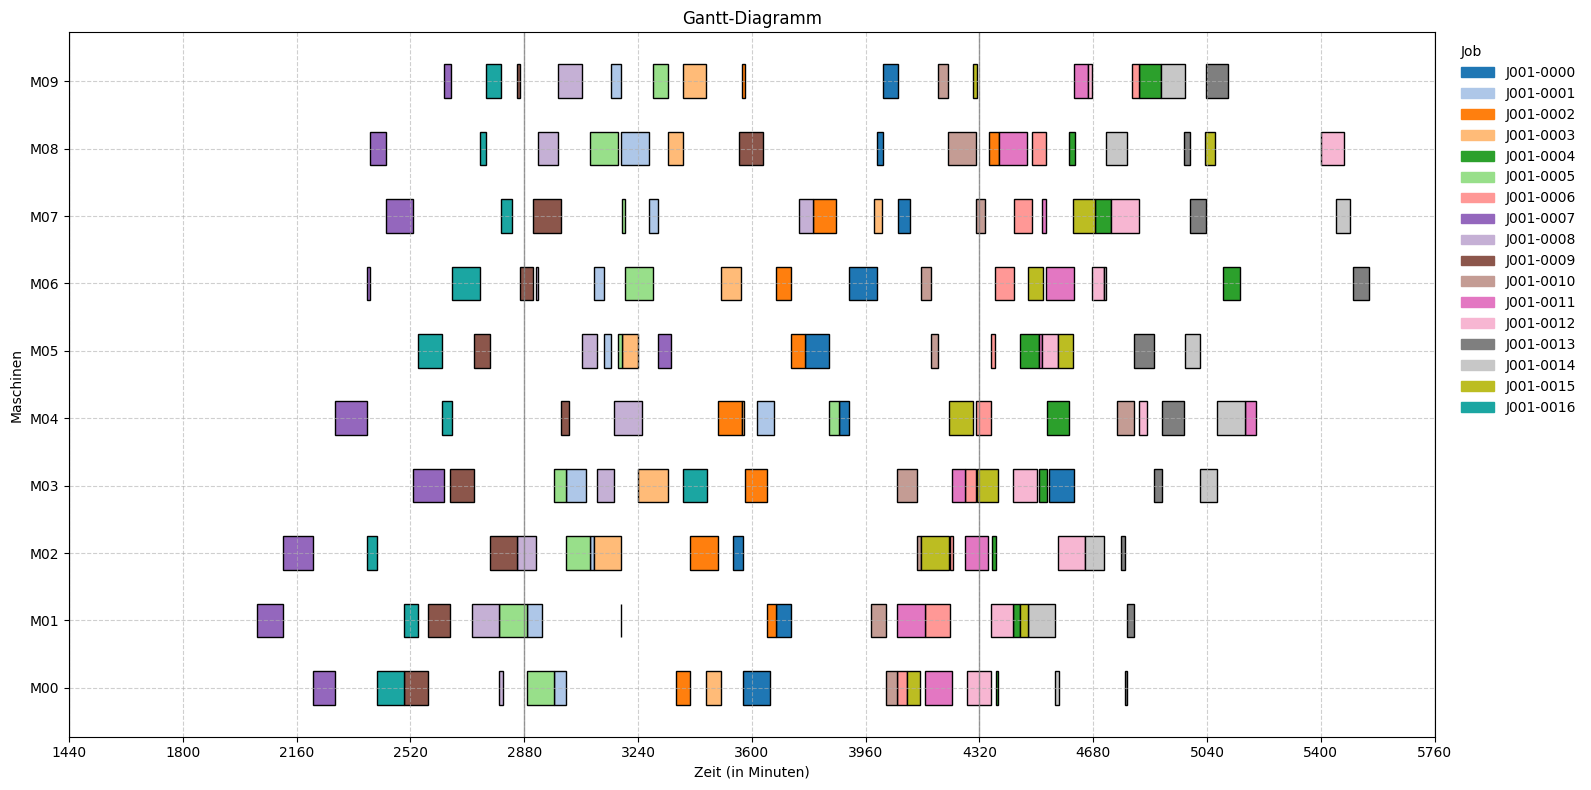

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [16]:
gantt.get_plot(df_schedule, perspective="Machine")
#df_schedule_with_info = enrich_schedule_dframe(df_schedule, df_jobs_times)
check.check_core_schedule_constraints(df_schedule)
check.is_start_correct(df_schedule, df_jobs_times_current)
check.is_duration_correct(df_schedule)


In [17]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,17,0,0,0


### Simulation

In [18]:
simulation.run(schedule_collection = job_schedule_collection, start_time = day_start, end_time=day_end)

[Day 1 09:56:00] Job J001-0007 started on M01
[Day 1 10:58:00] Job J001-0007 finished on M01 (after 62 minutes)
[Day 1 11:17:00] Job J001-0007 started on M02
[Day 1 12:17:00] Job J001-0007 finished on M02 (after 60 minutes)
[Day 1 12:52:00] Job J001-0007 started on M00
[Day 1 14:18:00] Job J001-0007 finished on M00 (after 86 minutes)
[Day 1 14:18:00] Job J001-0007 started on M04
[Day 1 15:42:00] Job J001-0016 started on M02
[Day 1 15:58:00] Job J001-0007 finished on M04 (after 100 minutes)
[Day 1 15:58:00] Job J001-0007 started on M06
[Day 1 16:08:00] Job J001-0007 finished on M06 (after 10 minutes)
[Day 1 16:08:00] Job J001-0007 started on M08
[Day 1 16:11:00] Job J001-0016 finished on M02 (after 29 minutes)
[Day 1 16:13:00] Job J001-0016 started on M00
[Day 1 17:24:00] Job J001-0007 finished on M08 (after 76 minutes)
[Day 1 17:24:00] Job J001-0007 started on M07
[Day 1 17:48:00] Job J001-0016 finished on M00 (after 95 minutes)
[Day 1 17:48:00] Job J001-0009 started on M00
[Day 1 17:4

In [19]:
finished_job_ops_collection = simulation.get_finished_operation_collection()
df_execution = finished_job_ops_collection.to_dataframe()
df_execution

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,J001-0007,None,0,M01,2036.0,62.0,2098.0,0,None
1,J001-0007,None,1,M02,2117.0,60.0,2177.0,0,None
2,J001-0007,None,2,M00,2212.0,86.0,2298.0,0,None
3,J001-0007,None,3,M04,2298.0,100.0,2398.0,0,None
4,J001-0007,None,4,M06,2398.0,10.0,2408.0,0,None
5,J001-0007,None,5,M08,2408.0,76.0,2484.0,0,None
...,...,...,...,...,...,...,...,...,...
19,J001-0009,None,1,M01,2575.0,82.0,2657.0,0,None
20,J001-0009,None,2,M03,2685.0,88.0,2773.0,0,None
21,J001-0009,None,3,M05,2773.0,50.0,2823.0,0,None


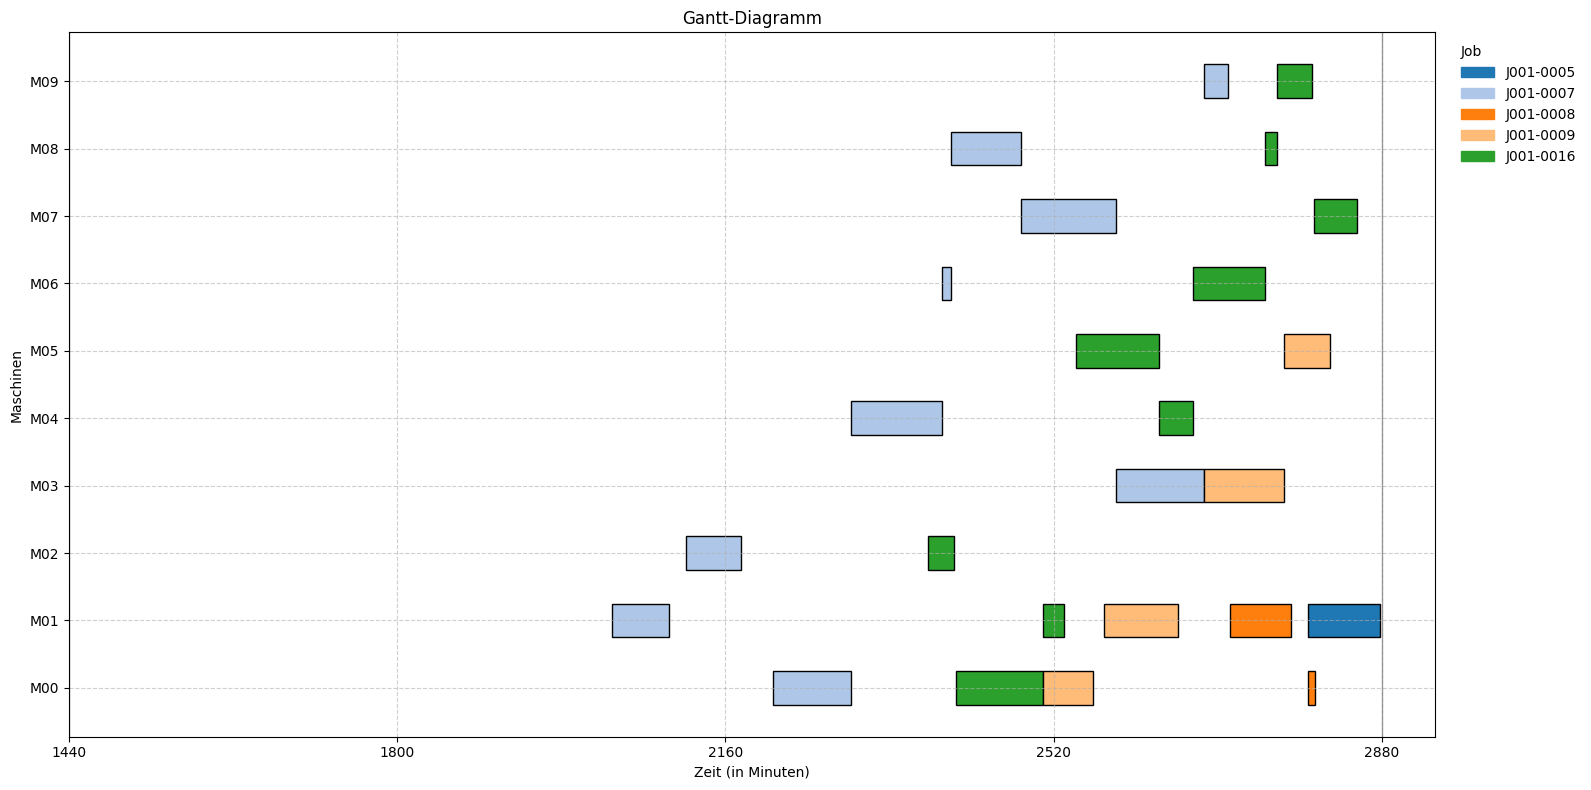

In [20]:
gantt.get_plot(df_execution, perspective="Machine")

In [21]:
active_job_ops_collection = simulation.get_active_operation_collection()
active_job_ops_collection.to_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,J001-0009,None,4,M02,2823.0,66.0,2889.0,0,None


In [22]:
waiting_job_ops_collection = simulation.get_waiting_operation_collection()
waiting_job_ops_collection.to_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,J001-0000,None,0,M02,3542,31,3573,0,None
1,J001-0000,None,1,M00,3573,86,3659,0,None
2,J001-0000,None,2,M01,3677,46,3723,0,None
3,J001-0000,None,3,M05,3769,74,3843,0,None
4,J001-0000,None,4,M04,3877,32,3909,0,None
5,J001-0000,None,5,M06,3909,88,3997,0,None
...,...,...,...,...,...,...,...,...,...
138,J001-0015,None,5,M01,4447,28,4475,0,None
139,J001-0015,None,6,M06,4475,46,4521,0,None
140,J001-0015,None,7,M05,4569,46,4615,0,None


## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [23]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [24]:
# New and previous jobs that must be scheduled
current_job_times_collection_temp = job_collection.get_subset_by_earliest_start(earliest_start=day_start)
current_job_times_collection = current_job_times_collection_temp + waiting_job_ops_collection

In [25]:
# Test
current_job_times_collection_temp.to_information_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J001-0017,5,1606,2880,6037
1,J001-0018,3,1656,2880,7290
2,J001-0019,0,1661,2880,5767
3,J001-0020,5,1670,2880,6124
4,J001-0021,3,1685,2880,6902
5,J001-0022,1,1729,2880,4811
...,...,...,...,...,...
23,J001-0040,3,2759,2880,6263
24,J001-0041,2,2785,2880,5956
25,J001-0042,1,2804,2880,6377


In [29]:
# Test
current_job_times_collection_temp.to_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,J001-0017,5,0,M02,None,84,None,2880,6037
1,J001-0017,5,1,M01,None,2,None,2880,6037
2,J001-0017,5,2,M05,None,52,None,2880,6037
3,J001-0017,5,3,M03,None,95,None,2880,6037
4,J001-0017,5,4,M08,None,48,None,2880,6037
5,J001-0017,5,5,M09,None,72,None,2880,6037
...,...,...,...,...,...,...,...,...,...
284,J001-0045,5,4,M08,None,48,None,2880,6799
285,J001-0045,5,5,M09,None,72,None,2880,6799
286,J001-0045,5,6,M00,None,47,None,2880,6799


In [27]:
current_job_times_collection.to_information_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J001-0017,5,1606.0,2880,6037.0
1,J001-0018,3,1656.0,2880,7290.0
2,J001-0019,0,1661.0,2880,5767.0
3,J001-0020,5,1670.0,2880,6124.0
4,J001-0021,3,1685.0,2880,6902.0
5,J001-0022,1,1729.0,2880,4811.0
...,...,...,...,...,...
40,J001-0011,None,NaN,0,NaN
41,J001-0012,None,NaN,0,NaN
42,J001-0013,None,NaN,0,NaN


In [28]:
current_job_times_collection.to_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,J001-0017,5,0,M02,NaN,84,NaN,2880,6037.0
1,J001-0017,5,1,M01,NaN,2,NaN,2880,6037.0
2,J001-0017,5,2,M05,NaN,52,NaN,2880,6037.0
3,J001-0017,5,3,M03,NaN,95,NaN,2880,6037.0
4,J001-0017,5,4,M08,NaN,48,NaN,2880,6037.0
5,J001-0017,5,5,M09,NaN,72,NaN,2880,6037.0
...,...,...,...,...,...,...,...,...,...
428,J001-0015,None,5,M01,4447.0,28,4475.0,0,NaN
429,J001-0015,None,6,M06,4475.0,46,4521.0,0,NaN
430,J001-0015,None,7,M05,4569.0,46,4615.0,0,NaN


### Scheduling Preparation

In [ ]:
# jssp dict and job times information dict
job_ops_dict = get_job_ops_dict(df_jssp_current)
times_dict = get_times_dict(df_jobs_times_current)

In [ ]:
active_ops = get_active_ops(df_active)
active_ops

In [ ]:
previous_schedule = schedule
df_previous_schedule = df_schedule

In [ ]:
schedule

In [ ]:
-

### Scheduling (Rescheduling)

#### a) Simple Scheduling

In [ ]:
schedule, experiment_log = solve_jssp_lateness_with_start_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=None,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=1,
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)


In [ ]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

In [ ]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

In [ ]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

### b) with 'start' deviation penalty

In [ ]:
schedule, experiment_log = solve_jssp_lateness_with_start_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=previous_schedule,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=(1/2),                  # 50% Lateness+, 50% Deviation
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)

sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"\nSum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

In [ ]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

### c) with 'order on machines' deviation penalty

In [ ]:
schedule, experiment_log = solve_jssp_lateness_with_order_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=previous_schedule,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=(1/2),                  # 50% Lateness+, 50% Deviation
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.001
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)

sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"\nSum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

In [ ]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

In [ ]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

#### Check the conditions of the combined data set from the simulation data with the new schedule

In [ ]:
df_reschedule = df_schedule

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)

### Simulation

In [ ]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time = day_end)

In [ ]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

In [ ]:
gantt.get_plot(df_execution2, perspective="Machine")

In [ ]:
df_active2 = simulation.get_active_operations_df()
df_active2

#### Check the conditions of the combined data set from the two simulation data sets

In [ ]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)